# Digital Forensics - Project 3
# General Adversarial Networks (GANs)
---
##### Carlo Facchin 1234374
---

### Tensorflow setup

In [1]:
import tensorflow as tf

#physical_devices = tf.config.list_physical_devices('GPU') 
#for gpu_instance in physical_devices: 
#    tf.config.experimental.set_memory_growth(gpu_instance, True)

configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)    
    
tf.__version__

'2.5.0'

In [2]:
# Verifying the use of GPU
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3499800282147049212
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4179427328
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7187471374597339300
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


### Libraries import

In [3]:
import glob
import imageio

import keras_tuner as kt

import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import PIL
import time
from scipy import stats

from keras.layers import Input, BatchNormalization
from keras.models import load_model, Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

from keras.utils.vis_utils import plot_model

from IPython import display

### Define dataset import and transformation functions

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
def import_dataset(dtype):

    if dtype == 'FashionMNIST':
        (train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
    if dtype == 'MNIST':
        (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
    if dtype == 'CIFAR-10':
        (train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()
        
    
    #Add a dimention to images, type int to float and rescale [0, 255] to [-1, 1]
    if ((dtype == 'FashionMNIST') or (dtype == 'MNIST')):
        train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
    if dtype == 'CIFAR-10':
        train_images = train_images.reshape(train_images.shape[0], 32, 32, 3)
        
    train_images= train_images.astype('float32') #size normalize
    train_images = (train_images - 127.5) / 127.5  #values in [-1, 1] 60000, 128, 50000, 64
    
    # I decided to use the dataset size of 60000 and a batch_size of 128 for MNIST
    if ((dtype == 'FashionMNIST') or (dtype == 'MNIST')):
        train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(128)
    
    # Dataset size of 50000 and a batch_size of 64 for CIFAR-10
    if dtype == 'CIFAR-10':
        train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(50000).batch(64)
    
    
    return train_dataset

## Model definition

### Generator

In [6]:
from keras import layers

In [7]:
# Build Generator with default latent_space=100
def generator_model_MNIST(lat_dim):
    
    weight_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    # Initialize the NN
    model = Sequential(name='generator')

    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(lat_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0 

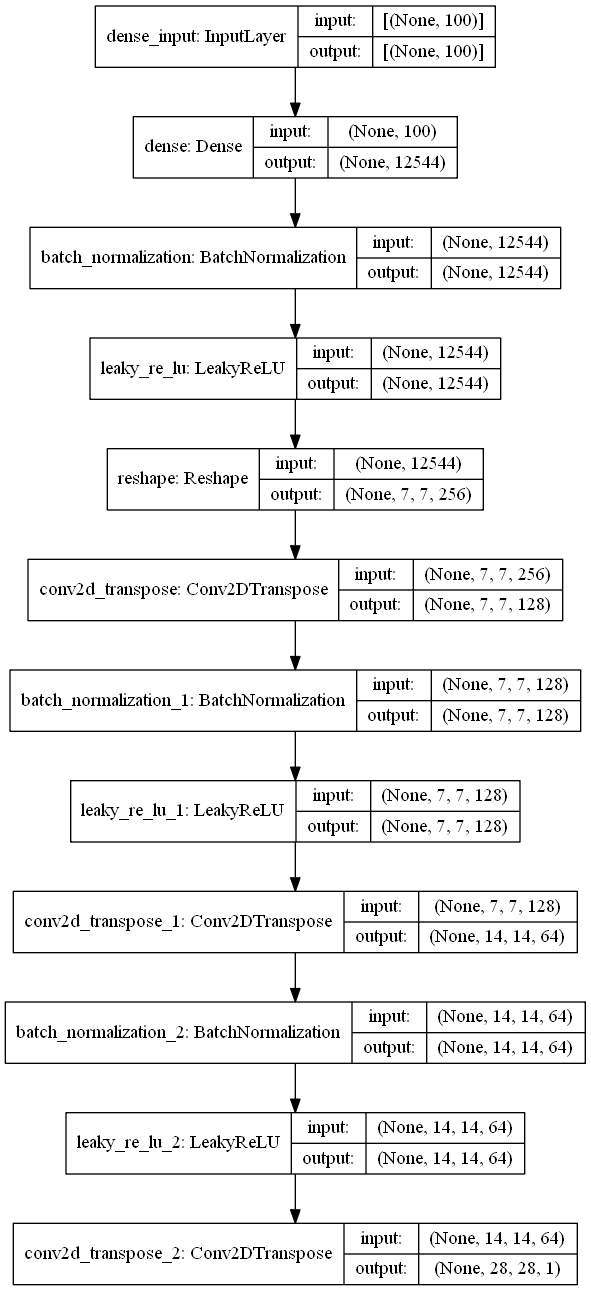

In [8]:
generator = generator_model_MNIST(lat_dim=100)
generator.summary()
plot_model(generator, to_file='G_MNIST.png', show_shapes=True, show_layer_names=True)

### Discriminator

In [9]:
def discriminator_model_MNIST(input_shape):

    # Initialize the NN
    model = Sequential(name='discriminator')

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)            

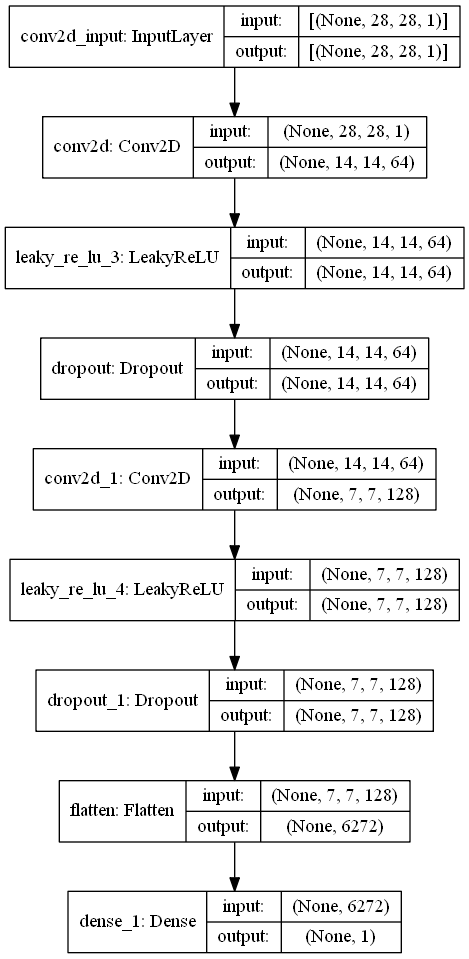

In [10]:
discriminator = discriminator_model_MNIST(input_shape=(28, 28, 1))
discriminator.summary()
plot_model(discriminator, to_file='D_MNIST.png', show_shapes=True, show_layer_names=True)

In [11]:
def combine_gd_models(G,D):

    optimizer_adam = Adam(lr=0.0002, beta_1=0.5)
    
    # Freeze discriminator weights during generator training
    D.trainable = False
    
    # Connect generator and discriminator
    GAN = Sequential()
    GAN.add(G)
    GAN.add(D)
    GAN.compile(loss='binary_crossentropy', optimizer=optimizer_adam, metrics=['accuracy'])
    return GAN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 28, 28, 1)         2330944   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 212865    
Total params: 2,543,809
Trainable params: 2,305,472
Non-trainable params: 238,337
_________________________________________________________________


C:\Users\carlo\anaconda3\envs\tf-gpu-env\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


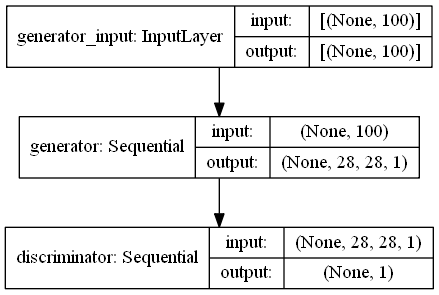

In [12]:
GAN_Structure = combine_gd_models(generator, discriminator)
GAN_Structure.summary()
plot_model(GAN_Structure, to_file='GAN_MNIST.png', show_shapes=True, show_layer_names=True)

### Saving plot and model functions

In [11]:
# Save generator and discriminator models
def save_model(epoch, G, D, name):
    
    # save the generator model tile file
    filename = f'Model/{name}/Generator/G_{epoch + 1}.h5'
    G.save(filename)
    
    # save the generator model tile file
    filename = f'Model/{name}/Discriminator/D_{epoch + 1}.h5'
    G.save(filename)

### Main parameters init

In [12]:
latent_dim = 100

# Instantiate one optimizer for the discriminator and another for the generator.
d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Instantiate a loss function.
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

d_metricsAcc=tf.keras.metrics.BinaryAccuracy()
g_metricsAcc=tf.keras.metrics.BinaryAccuracy()



### Train batch_step function

In [13]:
@tf.function
def train_step(real_images):
    
    batchSize = tf.shape(real_images)[0]
    
    # noise vector, input for the generator
    noise = tf.random.normal(shape=(batchSize, latent_dim))
    
    #concatenate the real and the fake labels
    y_true = tf.concat(
        [
            #the real images as label 1
            tf.ones(batchSize, 1),
            #the fake images generated as label 0
            tf.zeros(batchSize, 1)
        ],
        axis = 0
    )
    
    # outputs are all classified as real by the generator
    y_true_misleading = tf.ones(batchSize, 1)
    
    # Discriminator training #################################################
    
    with tf.GradientTape() as tape:
        #generate fake samples
        fake_images = generator(noise)
        #concatenate real data and fake data
        x = tf.concat([real_images, fake_images], axis=0)
        # see if the discriminator detect them
        y_pred = discriminator(x)
        # calculate the loss
        discriminatorLoss = loss_fn(y_true, y_pred)
        
    # backward path and weight update
    grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))
    
    #report accuracy
    d_metricsAcc.update_state(y_true, y_pred)
    
    # Generator training ###############################################
    
    with tf.GradientTape() as tape:
        generated_images = generator(noise)
        y_pred = discriminator(generated_images)
        generatorLoss = loss_fn(y_true_misleading, y_pred)
        
    grads = tape.gradient(generatorLoss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
        
    g_metricsAcc.update_state(y_true_misleading, y_pred)
    
    #####################
    
    return discriminatorLoss, generatorLoss, d_metricsAcc.result(), g_metricsAcc.result(), generated_images

### Plot functions

In [14]:
def plotImages(G, epoch, name):
    
    images = G(tf.random.normal(shape=(16, 100)), training = False)
    
    plt.figure(figsize=(8,8))
    
    for im in range(images.shape[0]):
        plt.subplot(4, 4, im+1)
        image = images[im, :, :, :]
        image = np.reshape(image, [28, 28])
            
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig(f'Output/{name}/{epoch}.png')
    plt.show()
    plt.close('all')

In [15]:
from numpy import sqrt

In [16]:
def plot_loss(dl, gl, dtype, e):
    # Compute epoch mean metrics
    
    epochs = e
    epoch = np.arange(0, epochs)

    plt.figure(figsize=(10,5))
    
    plt.plot(epoch, dl, label='D-loss')
    plt.plot(epoch, gl, label='G-loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{dtype} Epoch Losses')
    #plt.xticks(epoch)
    plt.legend()
    plt.ylim(0, 3)
    plt.savefig(f'Graphs/{dtype}/epoch_loss.png')
    plt.show()
    plt.close('all')

In [17]:
def plot_accuracy(da, ga, dtype, e):
    # Compute epoch mean metrics

    epochs = e
    epoch = np.arange(0, epochs)

    plt.figure(figsize=(10,5))

    plt.figure(figsize=(10,5))
    plt.plot(epoch, da, label='D-accuracy')
    plt.plot(epoch, ga, label='G-accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{dtype} Epoch Accuracy')
    #plt.xticks(epoch)
    plt.legend()
    plt.ylim(0, 2)
    plt.savefig(f'Graphs/{dtype}/epoch_accuracy.png')
    plt.show()
    plt.close('all')

In [18]:
def gen_images(latent_space, G, sample_number, name):
    
    tmp_noise = np.random.randn(sample_number * latent_space).reshape(sample_number,latent_space)

    images = G.predict(tmp_noise)

    plt.figure(figsize=(10,10))

    for im in range(images.shape[0]):
        plt.subplot(np.sqrt(sample_number), np.sqrt(sample_number), im+1)
        image = images[im, :, :, :]
        image = np.reshape(image, [28, 28])

        plt.imshow(image, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'{name}.png')
    plt.show()
    plt.close('all')

### Entire training function

In [19]:
def train(dtype, generator, discriminator, e):
    
    epochs = e
    dataset = import_dataset(dtype)
    
    D_loss = []
    D_acc = []   
    G_loss = []
    G_acc = []

    eval_time = []

    for epoch in range(epochs):


        # Save model every 10 epochs
        if ((epoch + 1) % 10) == 0:
            save_model(epoch, generator, discriminator, dtype)

        start_t = time.time()

        for step, real_images in enumerate(dataset):

            # Train the discriminator & generator on one batch of real images.
            d_loss, g_loss, d_acc, g_acc, generated_images = train_step(real_images)


        end_t = time.time()

        eval_time.append(end_t - start_t)

        D_loss.append(d_loss)
        D_acc.append(d_acc)

        G_loss.append(g_loss)
        G_acc.append(g_acc)
        
        if ((((epoch+1) % 10) == 0) or (epoch == 0)):
            plotImages(generator, epoch, dtype)

        # Print epoch mean value
        print('Epoch-%2d: dl=%.3f gl=%.3f da=%.3f ga=%.3f time=%.3f' %(epoch, d_loss, g_loss, d_acc, g_acc, (eval_time[epoch])))

    return D_loss, D_acc, G_loss, G_acc

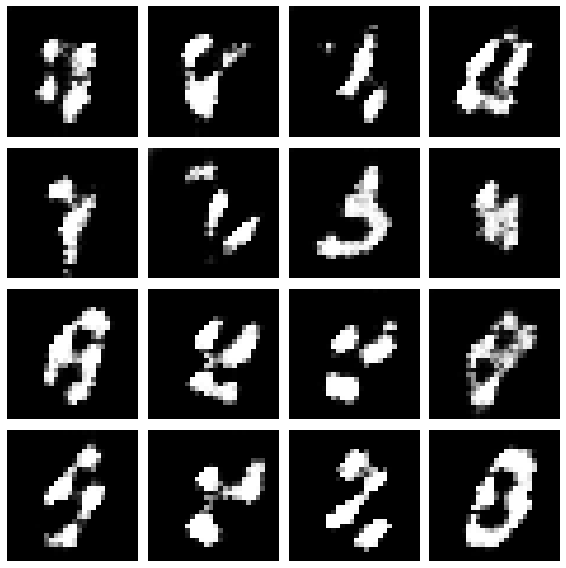

Epoch- 0: dl=0.600 gl=0.816 da=0.717 ga=0.014 time=19.870
Epoch- 1: dl=0.619 gl=0.853 da=0.685 ga=0.023 time=16.460
Epoch- 2: dl=0.641 gl=0.860 da=0.666 ga=0.030 time=16.570
Epoch- 3: dl=0.654 gl=0.880 da=0.647 ga=0.034 time=16.505
Epoch- 4: dl=0.660 gl=0.833 da=0.631 ga=0.034 time=16.320
Epoch- 5: dl=0.609 gl=1.187 da=0.623 ga=0.033 time=16.845
Epoch- 6: dl=0.610 gl=0.833 da=0.619 ga=0.034 time=16.470
Epoch- 7: dl=0.601 gl=0.932 da=0.616 ga=0.034 time=16.270
Epoch- 8: dl=0.645 gl=0.724 da=0.615 ga=0.035 time=16.250


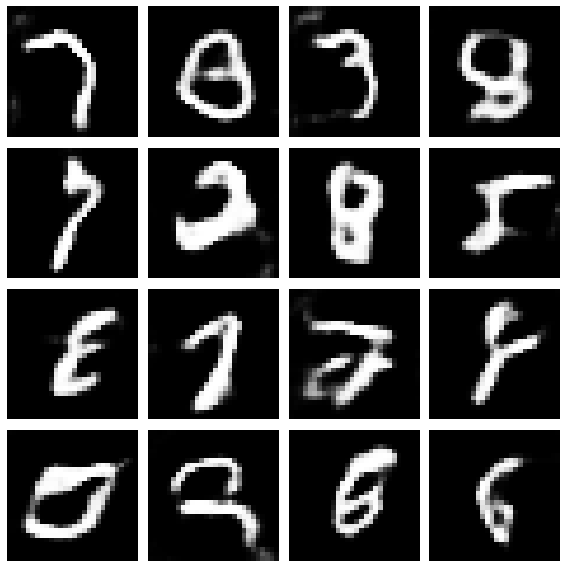

Epoch- 9: dl=0.626 gl=0.768 da=0.615 ga=0.036 time=16.275
Epoch-10: dl=0.660 gl=1.072 da=0.615 ga=0.037 time=16.190
Epoch-11: dl=0.605 gl=0.747 da=0.615 ga=0.039 time=16.220
Epoch-12: dl=0.647 gl=0.737 da=0.615 ga=0.040 time=16.205
Epoch-13: dl=0.635 gl=0.636 da=0.616 ga=0.041 time=16.220
Epoch-14: dl=0.662 gl=0.585 da=0.616 ga=0.042 time=16.220
Epoch-15: dl=0.613 gl=0.966 da=0.616 ga=0.044 time=16.207
Epoch-16: dl=0.629 gl=0.799 da=0.616 ga=0.045 time=16.200
Epoch-17: dl=0.651 gl=1.021 da=0.617 ga=0.046 time=16.220
Epoch-18: dl=0.668 gl=0.906 da=0.617 ga=0.047 time=16.200


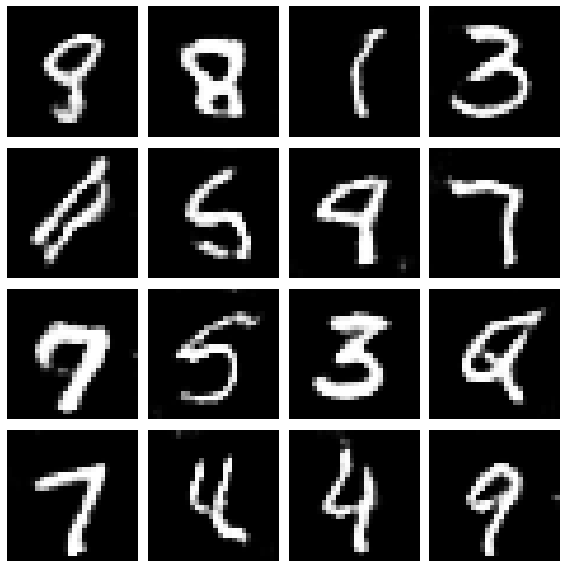

Epoch-19: dl=0.609 gl=0.894 da=0.617 ga=0.048 time=16.210
Epoch-20: dl=0.570 gl=0.953 da=0.618 ga=0.049 time=16.228
Epoch-21: dl=0.666 gl=1.109 da=0.618 ga=0.050 time=16.205
Epoch-22: dl=0.567 gl=0.896 da=0.619 ga=0.051 time=16.180
Epoch-23: dl=0.587 gl=0.816 da=0.620 ga=0.052 time=16.199
Epoch-24: dl=0.599 gl=0.798 da=0.620 ga=0.053 time=16.220
Epoch-25: dl=0.620 gl=1.075 da=0.621 ga=0.054 time=16.220
Epoch-26: dl=0.608 gl=0.797 da=0.622 ga=0.055 time=16.210
Epoch-27: dl=0.584 gl=0.936 da=0.622 ga=0.055 time=16.190
Epoch-28: dl=0.598 gl=0.802 da=0.623 ga=0.056 time=16.180


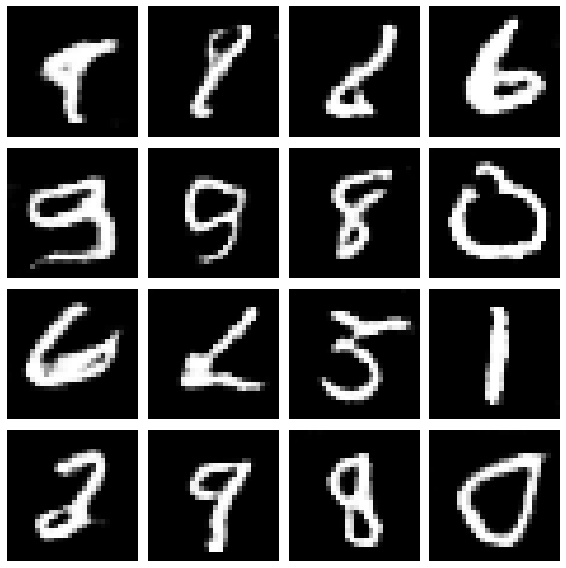

Epoch-29: dl=0.613 gl=0.707 da=0.624 ga=0.057 time=16.179
Epoch-30: dl=0.553 gl=1.005 da=0.624 ga=0.058 time=16.260
Epoch-31: dl=0.619 gl=0.875 da=0.625 ga=0.059 time=16.251
Epoch-32: dl=0.581 gl=1.182 da=0.625 ga=0.059 time=16.236
Epoch-33: dl=0.569 gl=1.108 da=0.626 ga=0.060 time=16.205
Epoch-34: dl=0.605 gl=0.880 da=0.627 ga=0.061 time=16.170
Epoch-35: dl=0.602 gl=0.737 da=0.627 ga=0.062 time=16.132
Epoch-36: dl=0.582 gl=1.063 da=0.628 ga=0.062 time=16.094
Epoch-37: dl=0.610 gl=1.384 da=0.628 ga=0.063 time=16.379
Epoch-38: dl=0.569 gl=1.118 da=0.629 ga=0.064 time=16.300


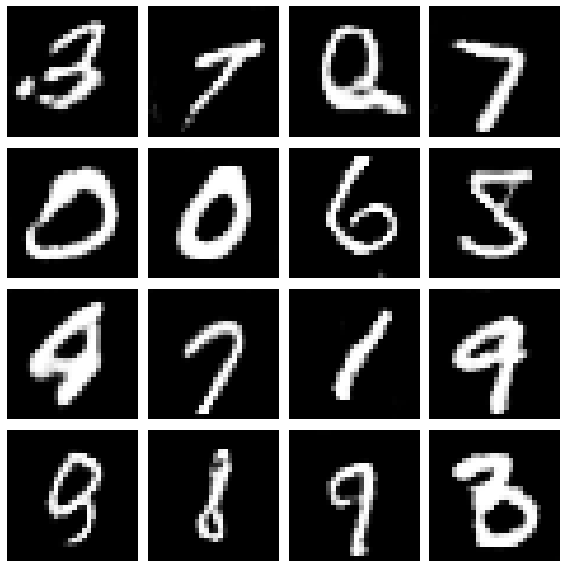

Epoch-39: dl=0.610 gl=0.794 da=0.629 ga=0.065 time=16.200
Epoch-40: dl=0.598 gl=0.914 da=0.630 ga=0.065 time=16.680
Epoch-41: dl=0.583 gl=0.904 da=0.630 ga=0.066 time=16.465
Epoch-42: dl=0.622 gl=0.866 da=0.630 ga=0.066 time=16.220
Epoch-43: dl=0.561 gl=1.011 da=0.631 ga=0.067 time=16.230
Epoch-44: dl=0.620 gl=0.894 da=0.631 ga=0.068 time=16.190
Epoch-45: dl=0.599 gl=0.857 da=0.631 ga=0.068 time=16.150
Epoch-46: dl=0.581 gl=1.266 da=0.632 ga=0.069 time=16.220
Epoch-47: dl=0.589 gl=1.027 da=0.632 ga=0.069 time=16.210
Epoch-48: dl=0.563 gl=1.168 da=0.632 ga=0.070 time=16.200


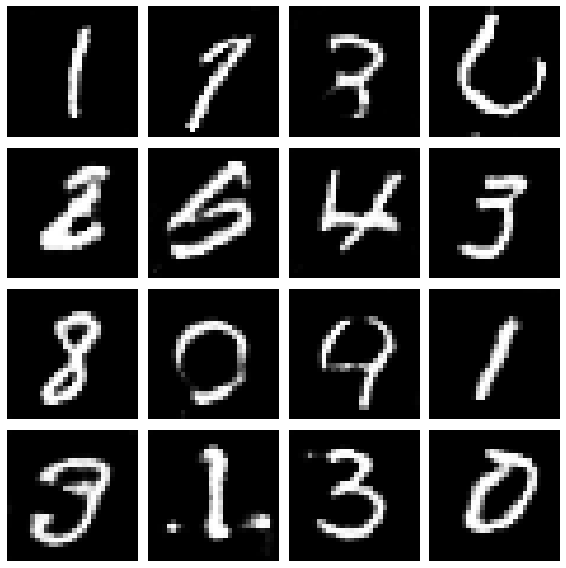

Epoch-49: dl=0.615 gl=1.074 da=0.632 ga=0.070 time=16.240


In [20]:
D_l, D_a, G_l, G_a = train('MNIST',generator, discriminator, 50)

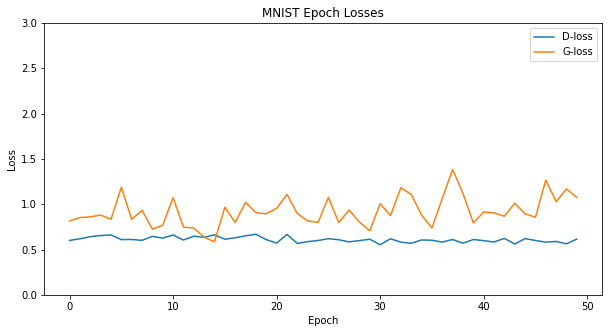

In [21]:
plot_loss(D_l, G_l, 'MNIST', 50)

<Figure size 720x360 with 0 Axes>

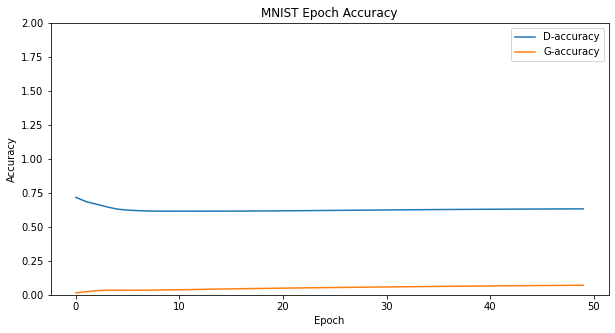

In [22]:
plot_accuracy(D_a, G_a, 'MNIST', 50)

C:\Users\carlo\AppData\Local\Temp/ipykernel_16740/3681131951.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(np.sqrt(sample_number), np.sqrt(sample_number), im+1)


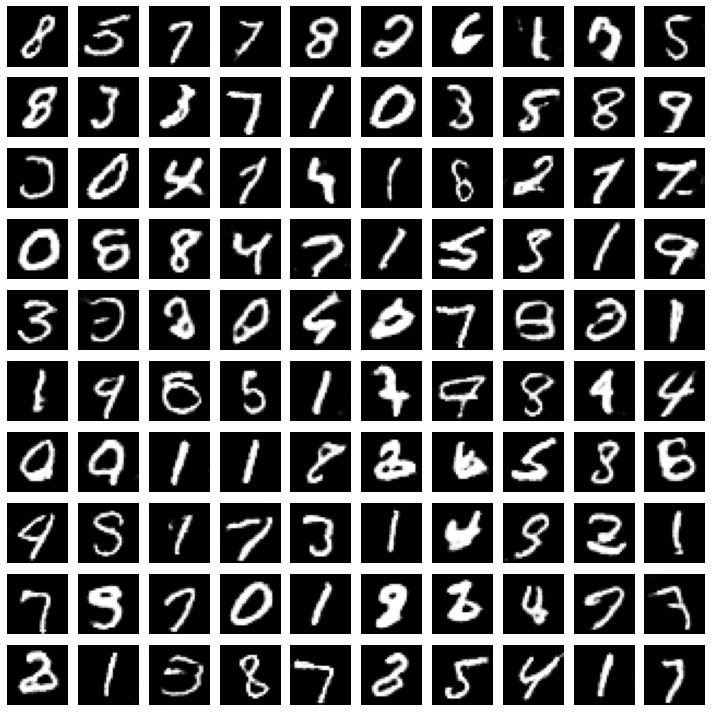

In [23]:
gen_images(100, generator, 100, 'MNIST')

### FashionMNIST

In [24]:
discriminator = discriminator_model_MNIST(input_shape=(28, 28, 1))
generator = generator_model_MNIST(lat_dim=100)

In [25]:
latent_dim = 100

# Instantiate one optimizer for the discriminator and another for the generator.
d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Instantiate a loss function.
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

d_metricsAcc=tf.keras.metrics.BinaryAccuracy()
g_metricsAcc=tf.keras.metrics.BinaryAccuracy()

In [26]:
@tf.function
def train_step(real_images):
    
    batchSize = tf.shape(real_images)[0]
    
    # noise vector, input for the generator
    noise = tf.random.normal(shape=(batchSize, latent_dim))
    
    #concatenate the real and the fake labels
    y_true = tf.concat(
        [
            #the real images as label 1
            tf.ones(batchSize, 1),
            #the fake images generated as label 0
            tf.zeros(batchSize, 1)
        ],
        axis = 0
    )
    
    # outputs are all classified as real by the generator
    y_true_misleading = tf.ones(batchSize, 1)
    
    # Discriminator training #################################################
    
    with tf.GradientTape() as tape:
        #generate fake samples
        fake_images = generator(noise)
        #concatenate real data and fake data
        x = tf.concat([real_images, fake_images], axis=0)
        # see if the discriminator detect them
        y_pred = discriminator(x)
        # calculate the loss
        discriminatorLoss = loss_fn(y_true, y_pred)
        
    # backward path and weight update
    grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))
    
    #report accuracy
    d_metricsAcc.update_state(y_true, y_pred)
    
    # Generator training ###############################################
    
    with tf.GradientTape() as tape:
        generated_images = generator(noise)
        y_pred = discriminator(generated_images)
        generatorLoss = loss_fn(y_true_misleading, y_pred)
        
    grads = tape.gradient(generatorLoss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
        
    g_metricsAcc.update_state(y_true_misleading, y_pred)
    
    #####################
    
    return discriminatorLoss, generatorLoss, d_metricsAcc.result(), g_metricsAcc.result(), generated_images

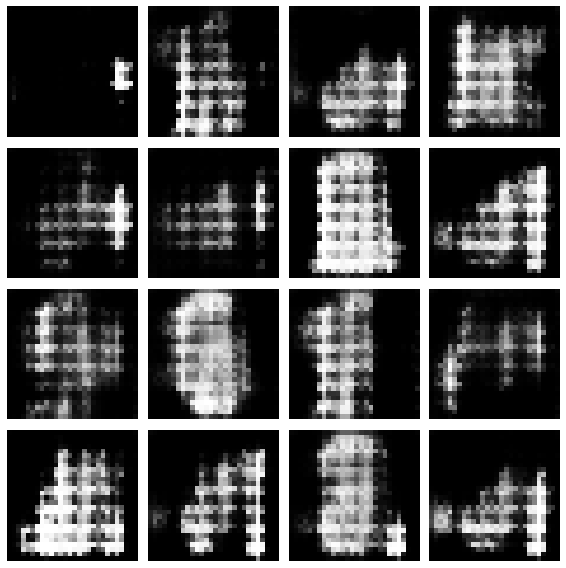

Epoch- 0: dl=0.670 gl=0.882 da=0.637 ga=0.008 time=18.078
Epoch- 1: dl=0.584 gl=0.967 da=0.608 ga=0.009 time=16.347
Epoch- 2: dl=0.631 gl=0.882 da=0.619 ga=0.012 time=16.240
Epoch- 3: dl=0.640 gl=0.789 da=0.611 ga=0.018 time=16.315
Epoch- 4: dl=0.669 gl=0.651 da=0.601 ga=0.018 time=16.305
Epoch- 5: dl=0.713 gl=0.944 da=0.593 ga=0.018 time=16.225
Epoch- 6: dl=0.661 gl=0.730 da=0.587 ga=0.019 time=16.230
Epoch- 7: dl=0.800 gl=0.945 da=0.582 ga=0.019 time=16.225
Epoch- 8: dl=0.681 gl=0.857 da=0.579 ga=0.019 time=16.221


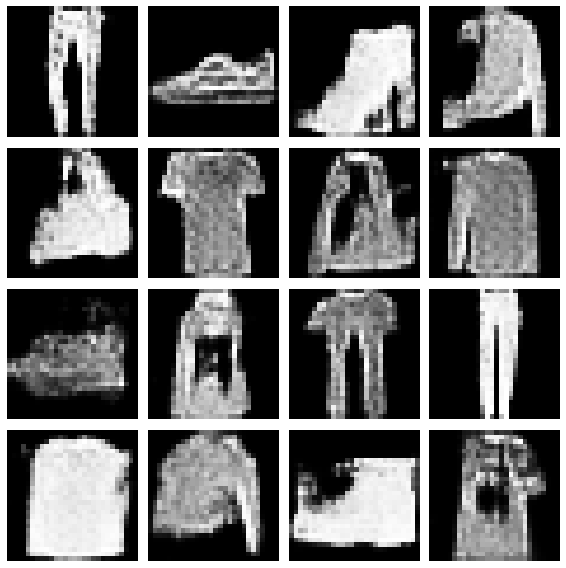

Epoch- 9: dl=0.657 gl=0.798 da=0.576 ga=0.020 time=16.230
Epoch-10: dl=0.673 gl=0.642 da=0.574 ga=0.020 time=16.240
Epoch-11: dl=0.657 gl=0.756 da=0.572 ga=0.020 time=16.280
Epoch-12: dl=0.674 gl=0.677 da=0.570 ga=0.020 time=16.255
Epoch-13: dl=0.661 gl=0.746 da=0.569 ga=0.020 time=16.260
Epoch-14: dl=0.666 gl=0.777 da=0.568 ga=0.020 time=16.230
Epoch-15: dl=0.663 gl=0.737 da=0.568 ga=0.020 time=16.243
Epoch-16: dl=0.658 gl=0.671 da=0.567 ga=0.020 time=16.200
Epoch-17: dl=0.673 gl=0.781 da=0.567 ga=0.021 time=16.240
Epoch-18: dl=0.662 gl=0.832 da=0.566 ga=0.021 time=16.260


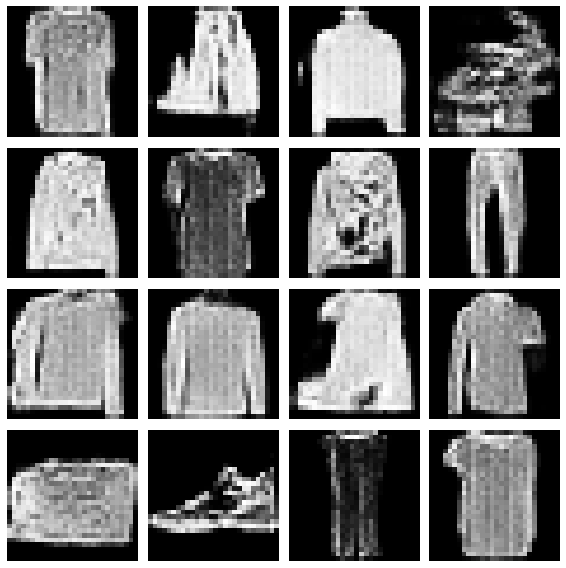

Epoch-19: dl=0.679 gl=0.951 da=0.566 ga=0.021 time=16.240
Epoch-20: dl=0.648 gl=0.723 da=0.566 ga=0.022 time=16.249
Epoch-21: dl=0.646 gl=0.709 da=0.566 ga=0.022 time=16.235
Epoch-22: dl=0.630 gl=0.923 da=0.566 ga=0.022 time=16.215
Epoch-23: dl=0.702 gl=0.678 da=0.566 ga=0.023 time=16.220
Epoch-24: dl=0.633 gl=0.906 da=0.566 ga=0.023 time=16.210
Epoch-25: dl=0.635 gl=0.776 da=0.566 ga=0.023 time=16.190
Epoch-26: dl=0.663 gl=0.768 da=0.567 ga=0.024 time=16.216
Epoch-27: dl=0.662 gl=0.790 da=0.567 ga=0.024 time=16.220
Epoch-28: dl=0.652 gl=0.938 da=0.567 ga=0.024 time=16.215


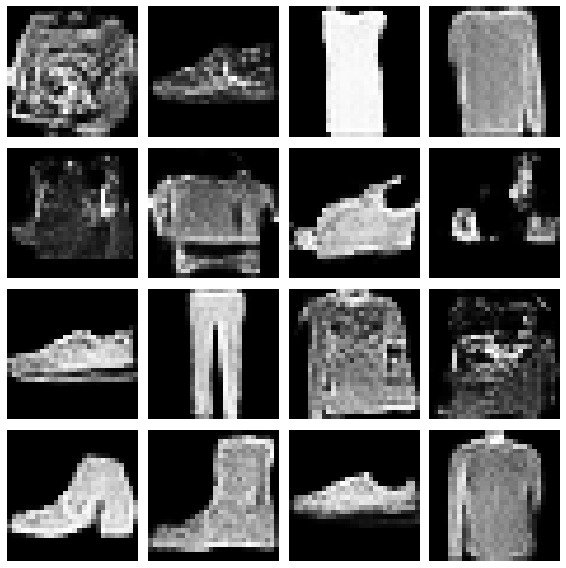

Epoch-29: dl=0.659 gl=0.807 da=0.567 ga=0.025 time=16.190
Epoch-30: dl=0.647 gl=1.006 da=0.567 ga=0.025 time=16.220
Epoch-31: dl=0.677 gl=0.691 da=0.568 ga=0.025 time=16.255
Epoch-32: dl=0.658 gl=0.803 da=0.568 ga=0.025 time=16.220
Epoch-33: dl=0.657 gl=0.828 da=0.568 ga=0.026 time=16.210
Epoch-34: dl=0.651 gl=0.663 da=0.568 ga=0.026 time=16.190
Epoch-35: dl=0.649 gl=0.747 da=0.569 ga=0.026 time=16.200
Epoch-36: dl=0.667 gl=0.804 da=0.569 ga=0.026 time=16.200
Epoch-37: dl=0.626 gl=0.792 da=0.569 ga=0.027 time=16.220
Epoch-38: dl=0.647 gl=0.798 da=0.569 ga=0.027 time=16.190


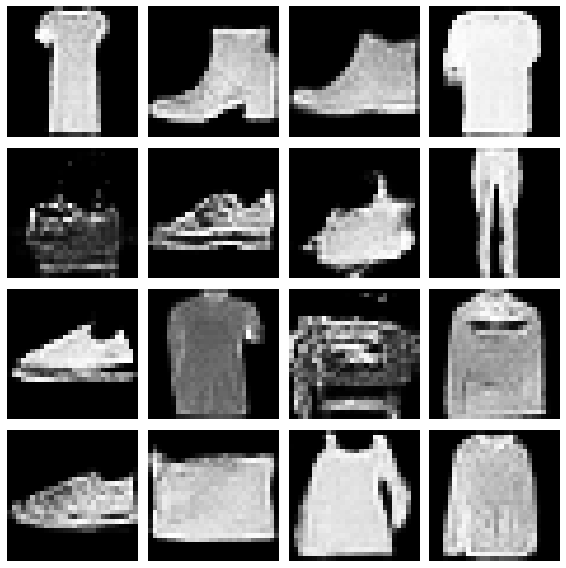

Epoch-39: dl=0.666 gl=0.698 da=0.570 ga=0.027 time=16.213
Epoch-40: dl=0.655 gl=1.030 da=0.570 ga=0.028 time=16.210
Epoch-41: dl=0.669 gl=0.893 da=0.570 ga=0.028 time=16.190
Epoch-42: dl=0.689 gl=0.930 da=0.570 ga=0.028 time=16.200
Epoch-43: dl=0.657 gl=0.685 da=0.571 ga=0.028 time=16.210
Epoch-44: dl=0.659 gl=0.757 da=0.571 ga=0.029 time=16.225
Epoch-45: dl=0.626 gl=0.834 da=0.571 ga=0.029 time=16.220
Epoch-46: dl=0.657 gl=0.771 da=0.571 ga=0.029 time=16.181
Epoch-47: dl=0.647 gl=0.870 da=0.572 ga=0.029 time=16.180
Epoch-48: dl=0.650 gl=0.920 da=0.572 ga=0.030 time=16.210


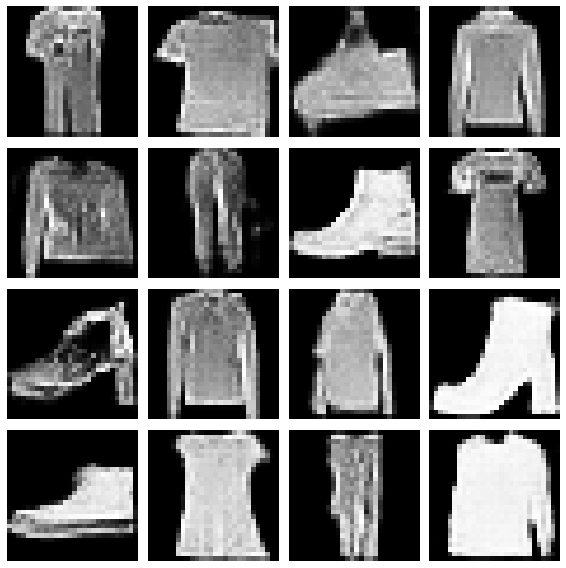

Epoch-49: dl=0.661 gl=0.805 da=0.572 ga=0.030 time=16.240


In [27]:
D_l, D_a, G_l, G_a = train('FashionMNIST',generator, discriminator, 50)

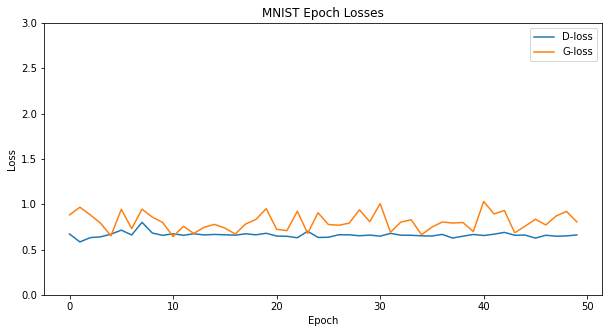

In [28]:
plot_loss(D_l, G_l, 'MNIST', 50)

<Figure size 720x360 with 0 Axes>

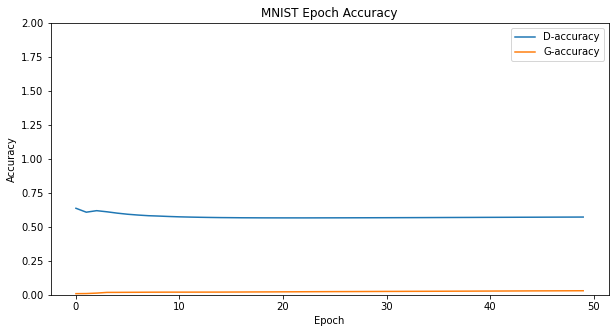

In [29]:
plot_accuracy(D_a, G_a, 'MNIST', 50)

C:\Users\carlo\AppData\Local\Temp/ipykernel_16740/3681131951.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(np.sqrt(sample_number), np.sqrt(sample_number), im+1)


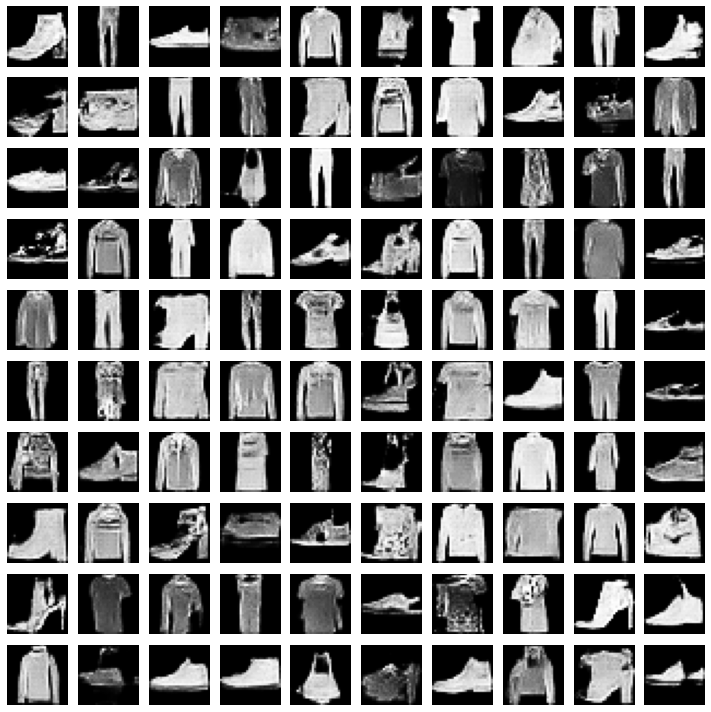

In [30]:
gen_images(100, generator, 100, 'FashionMNIST')

# CelebA dataset

### Libraries (torch) import

In [7]:
import random 

import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
from __future__ import print_function
import optuna
import random

### Data inport and transformation

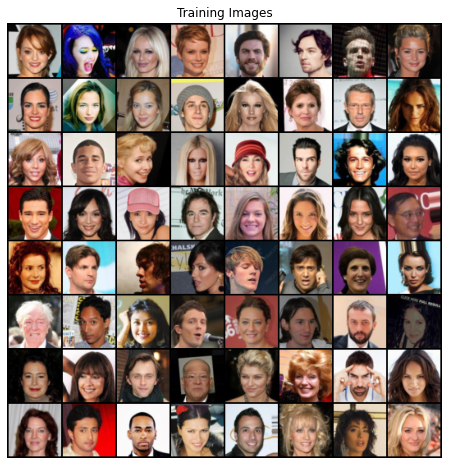

In [8]:
dataroot = "celeba"

random.seed(0)
torch.manual_seed(0)

image_size = 64
batch_size = 128

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                         shuffle=True, num_workers=2)

# Decide which device we want to run on

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Weight initialization function definition

In [9]:
# custom weights initialization called on the generator and on the discriminator
def weights_init(m):
    
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
encoded_space_dim = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64

### Generator and Discriminator

In [10]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d( encoded_space_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)
    
#############################################################################    
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

### Training

In [11]:
def train_epoch(dataloader, device, real_label, fake_label, loss_fn, optimizerD, optimizerG): 
    
    D_l_real = []
    D_l_fake = []
    D_l_total = []
    G_l = []
    
    for i, data in enumerate(dataloader, 0):

        ############################
        #Update Discriminator

        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = loss_fn(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, encoded_space_dim, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = loss_fn(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        #Update Generator
        
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = loss_fn(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        D_l_real.append(errD_real.detach().cpu().numpy())
        D_l_fake.append(errD_fake.detach().cpu().numpy())
        D_l_total.append(errD.detach().cpu().numpy())
        G_l.append(errG.detach().cpu().numpy())
        
    return np.mean(D_l_real), np.mean(D_l_fake), np.mean(D_l_total), np.mean(G_l)


def training_gan(num_epochs, dataloader, device, real_label, fake_label, loss_fn, optimizerD, 
                 optimizerG, fixed_noise, verbose_every_number, image_figure, loss_plot):
    # Training Loop
    print("Training started")
    
    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses_real = []
    D_losses_fake = []
    D_losses = []

    # For each epoch
    for epoch in range(num_epochs):
        
        lossD_real, lossD_fake, lossD, lossG = train_epoch(dataloader, device, real_label, fake_label, loss_fn, optimizerD, optimizerG)
        
        D_losses_real.append(lossD_real)
        D_losses_fake.append(lossD_fake)
        D_losses.append(lossD)
        G_losses.append(lossG)
    
        if (epoch==0 or ((epoch + 1)%verbose_every_number == 0)):
                print('EPOCH %d/%d - Discriminator_tot_loss: %f - Generator_loss: %f' % (epoch + 1, num_epochs, lossD, lossG))

                if (image_figure==True):
                    
                    with torch.no_grad():
                        fake = netG(fixed_noise).detach().cpu()
                        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
                        
                        plt.plot(figsize=(15,15))
                        plt.imshow(np.transpose(img_list[-1],(1,2,0)))
                        plt.axis("off")
                        plt.title('Generated images')
                        plt.show()
                        plt.close()
                        
    ### Plots
    if (loss_plot == True):
        
        plt.figure(figsize=(12,8))
        plt.plot(D_losses_real[1:], label='Discriminator_real_loss')
        plt.plot(D_losses_fake[1:], label='Discriminator_fake_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title("Discriminator real and fake losses")
        plt.grid()
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(12,8))
        plt.plot(D_losses[1:], label='Discriminator_tot_loss')
        plt.plot(G_losses[1:], label='Generator_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title("Discriminator and Generator Loss")
        plt.grid()
        plt.legend()
        plt.show()    
      
    return img_list

### Training main cycle

Training started
EPOCH 1/20 - Discriminator_tot_loss: 0.666120 - Generator_loss: 5.063086


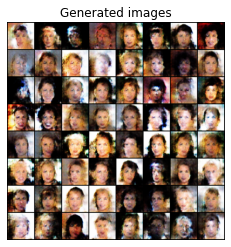

EPOCH 2/20 - Discriminator_tot_loss: 0.660767 - Generator_loss: 3.470767


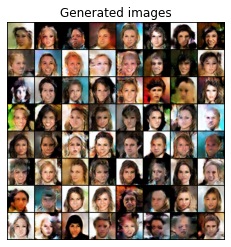

EPOCH 3/20 - Discriminator_tot_loss: 0.757797 - Generator_loss: 2.654829


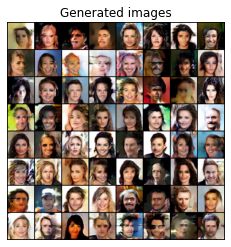

EPOCH 4/20 - Discriminator_tot_loss: 0.787255 - Generator_loss: 2.512973


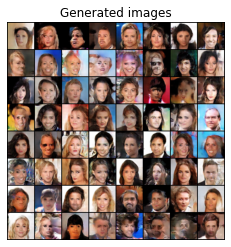

EPOCH 5/20 - Discriminator_tot_loss: 0.781157 - Generator_loss: 2.514405


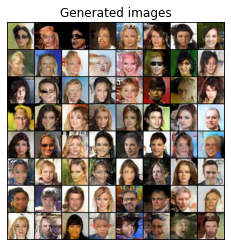

EPOCH 6/20 - Discriminator_tot_loss: 0.722781 - Generator_loss: 2.586467


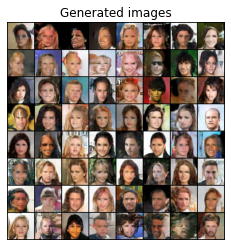

EPOCH 7/20 - Discriminator_tot_loss: 0.673524 - Generator_loss: 2.732418


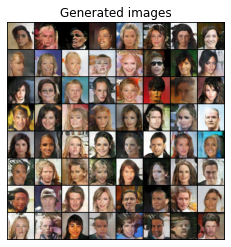

EPOCH 8/20 - Discriminator_tot_loss: 0.667235 - Generator_loss: 2.799866


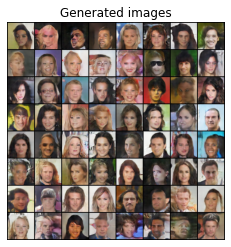

EPOCH 9/20 - Discriminator_tot_loss: 0.625971 - Generator_loss: 2.867282


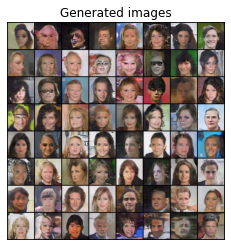

EPOCH 10/20 - Discriminator_tot_loss: 0.560567 - Generator_loss: 3.055863


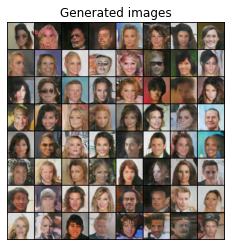

EPOCH 11/20 - Discriminator_tot_loss: 0.516997 - Generator_loss: 3.273655


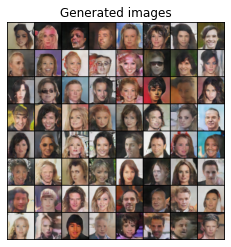

EPOCH 12/20 - Discriminator_tot_loss: 0.522386 - Generator_loss: 3.297263


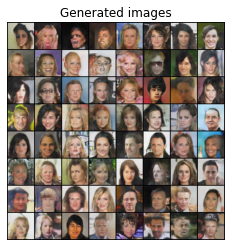

EPOCH 13/20 - Discriminator_tot_loss: 0.556895 - Generator_loss: 3.313939


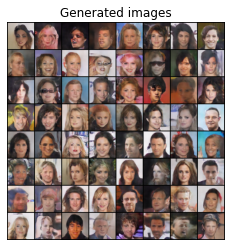

EPOCH 14/20 - Discriminator_tot_loss: 0.415432 - Generator_loss: 3.644504


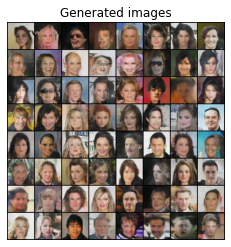

EPOCH 15/20 - Discriminator_tot_loss: 0.400281 - Generator_loss: 3.745214


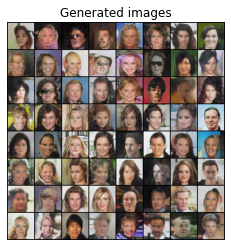

EPOCH 16/20 - Discriminator_tot_loss: 0.407767 - Generator_loss: 3.885704


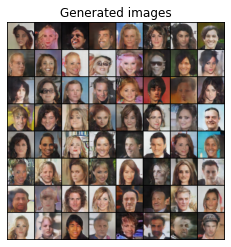

EPOCH 17/20 - Discriminator_tot_loss: 0.385030 - Generator_loss: 3.900208


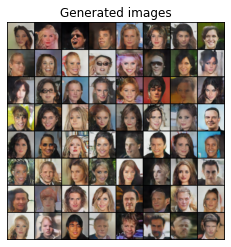

EPOCH 18/20 - Discriminator_tot_loss: 0.386685 - Generator_loss: 4.056756


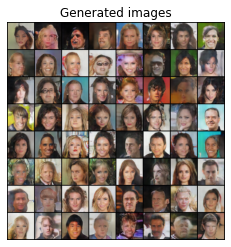

EPOCH 19/20 - Discriminator_tot_loss: 0.368018 - Generator_loss: 4.173980


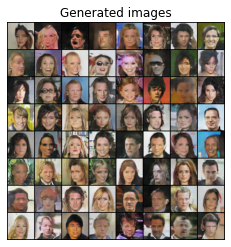

EPOCH 20/20 - Discriminator_tot_loss: 0.356095 - Generator_loss: 4.245242


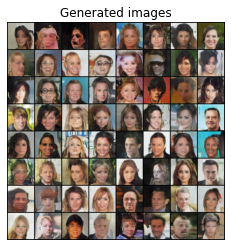

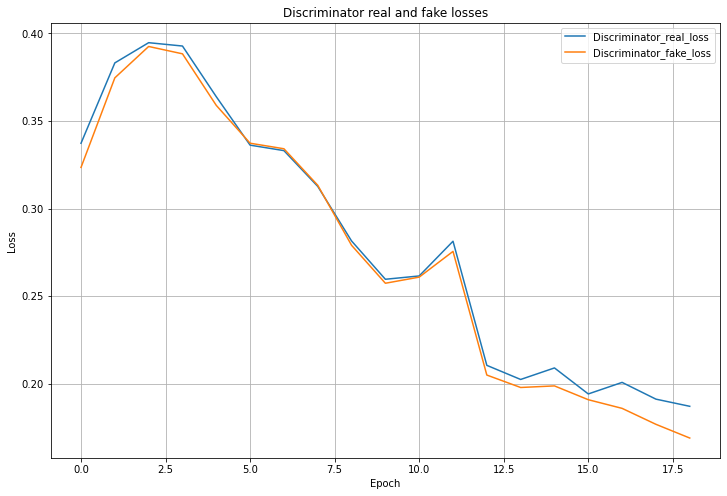

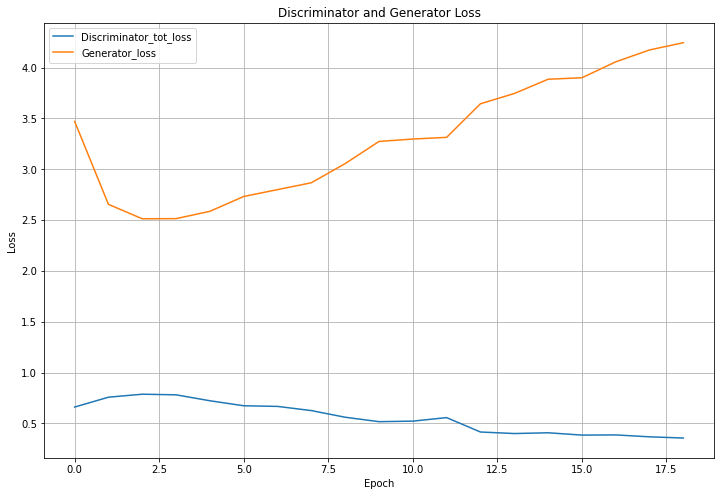

Training time 20 epochs [s]: 13525.692969322205


In [12]:
netG = Generator().to(device)
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)
netD.apply(weights_init)

#############################################################

loss_fn = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the images of the generator
fixed_noise = torch.randn(64, encoded_space_dim, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizer
lr = 0.0002

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
##############################################################
num_epochs = 20

i = time.time()
gen_imgs = training_gan(num_epochs, dataloader, device, real_label, fake_label, loss_fn, optimizerD, 
                 optimizerG, fixed_noise, verbose_every_number=1, image_figure=True, loss_plot=True)
f = time.time()
print("Training time 20 epochs [s]:", (f-i))

### Three epochs training

Training started
EPOCH 1/3 - Discriminator_tot_loss: 0.352733 - Generator_loss: 4.355082


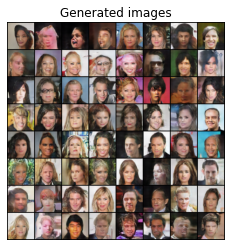

EPOCH 2/3 - Discriminator_tot_loss: 0.350032 - Generator_loss: 4.424937


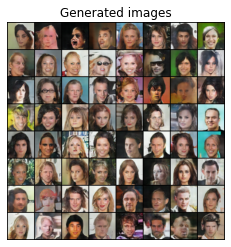

EPOCH 3/3 - Discriminator_tot_loss: 0.277314 - Generator_loss: 4.654830


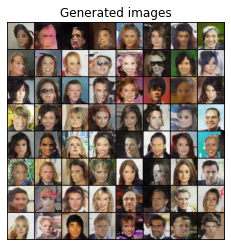

In [19]:
num_epochs = 3
gen_imgs = training_gan(num_epochs, dataloader, device, real_label, fake_label, loss_fn, optimizerD, 
                 optimizerG, fixed_noise, verbose_every_number=1, image_figure=True, loss_plot=False)